In [1]:
from torchvision.datasets import CIFAR10
from torchvision.transforms.functional import to_tensor
import torch

device = "cuda:7"
data = CIFAR10(root="/mnt/ssd-1/alexm/cifar10/", download=True)
images, labels = zip(*data)

X = torch.stack(list(map(to_tensor, images))).to(device)
Y = torch.tensor(labels).to(device)

# Shuffle deterministically
rng = torch.Generator(device=X.device).manual_seed(42)
perm = torch.randperm(len(X), generator=rng, device=X.device)
X, Y = X[perm], Y[perm]

X_vec = X.view(X.shape[0], -1)
k = int(Y.max()) + 1

test_size = 1024

X_vec_train = X_vec[:-test_size]
X_vec_test = X_vec[-test_size:]

X_train, X_test = X[:-test_size], X[-test_size:]
Y_train, Y_test = Y[:-test_size], Y[-test_size:]

Files already downloaded and verified


In [2]:
# state = torch.load("/home/nora/Data/erasers.pt")
# oleace = state['oleace']
# qleace = state['qleace']

state = torch.load('/mnt/ssd-1/lucia/ngrams-across-time/erasers_cache/cifar10_state.pth')
qleace = state['qleace'].to(device)
oleace = state['oleace'].to(device)

/tmp/ipykernel_956395/225487411.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load('/mnt/ssd-1/lucia/ngrams-across-time/erasers_cache/cifar10_state.pth')

In [3]:
import torch
from torch import Tensor, optim

from mdl.probe import Probe
from mlp_mixer_pytorch import MLPMixer


class MixerProbe(Probe):
    """Multi-layer perceptron with ResNet architecture."""

    def __init__(
        self,
        num_features: int,
        num_classes: int = 2,
        device: str | torch.device = "cpu",
        dtype: torch.dtype | None = None,
    ):
        super().__init__(num_features, num_classes, device, dtype)

        self.mixer = MLPMixer(
            image_size=32,
            channels=3,
            patch_size=4,
            dim=768,
            depth=16,
            num_classes=k,
        ).to(dtype=dtype).to(device=device)

    def forward(self, x: Tensor) -> Tensor:
        return self.mixer(x).squeeze(-1)

    def build_optimizer(self) -> optim.Optimizer:
        return optim.SGD(
            self.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4,
        )


class VitProbe(Probe):
    def __init__(
        self,
        num_classes: int = 2,
        device: str | torch.device = "cpu",
        dtype: torch.dtype | None = None,
    ):
        super().__init__(3, num_classes, device, dtype)

        from vit_pytorch import ViT

        self.vit = ViT(
            channels=3,
            depth=6,
            dim=512,
            dropout=0.1,
            #emb_dropout=0.1,
            heads=8,
            image_size=32,
            mlp_dim=1024,
            num_classes=k,
            patch_size=4,
        ).to(dtype=dtype).to(device=device)

    def forward(self, x: Tensor) -> Tensor:
        return self.vit(x).squeeze(-1)

    def build_optimizer(self) -> optim.Optimizer:
        # Implicitly does learning rate warmup in a principled way
        #return optim.SGD(self.parameters(), lr=0.005, momentum=0.9, weight_decay=0.1)
        return optim.Adam(self.parameters())

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from torchvision.transforms.v2 import RandAugment, AutoAugment
import torchvision as tv

image_size = X.shape[-1]
padding = round(image_size * 0.125)
augmentor = tv.transforms.Compose(
    [
        tv.transforms.RandomCrop(image_size, padding=padding),
        tv.transforms.RandomHorizontalFlip(),
        #tv.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        # AutoAugment()
    ]
)

In [5]:
print(X.shape)
print(X_vec.shape)

torch.Size([50000, 3, 32, 32])
torch.Size([50000, 3072])


In [6]:
# X_train.bfloat16().repeat(3, 1, 1, 1).flatten(1).shape
Y_train.repeat(3).shape
# Y_train.shape

torch.Size([146928])

In [7]:
from mdl import Sweep, ResMlpProbe

num_epochs = 1
num_seeds = 3

def reshape(x):
    "reshape tensor to CxHxW"
    return x.view(-1, X.shape[1], X.shape[2], X.shape[3])

flattened_image_augmentor = tv.transforms.Compose(
    [
        tv.transforms.Lambda(reshape),
        tv.transforms.RandomCrop(image_size, padding=padding),
        tv.transforms.RandomHorizontalFlip(),
        tv.transforms.Lambda(lambda x: x.flatten(1)),
    ]
)
sweep = Sweep(
    X_vec.shape[1], k, device=X.device, dtype=torch.bfloat16,
    num_chunks=10,
    probe_cls=ResMlpProbe,
    probe_kwargs=dict(num_layers=3),
)

In [8]:
results = [
    sweep.run(
        X_train.bfloat16().repeat(num_epochs, 1, 1, 1).flatten(1), Y_train.repeat(num_epochs), seed=i, 
        augment=flattened_image_augmentor, reduce_lr_on_plateau=False
    )
    for i in range(num_seeds)
]

100%|██████████| 9/9 [00:57<00:00,  6.40s/scales, loss=2.1336]


In [9]:
results_ = [
    sweep.run(
        X_train.bfloat16().repeat(num_epochs, 1, 1, 1).flatten(1), Y_train.repeat(num_epochs), seed=i,
        transform=lambda x, y: qleace(x, y),
        augment=flattened_image_augmentor,
    )
    for i in range(num_seeds)
]

100%|██████████| 9/9 [00:46<00:00,  5.14s/scales, loss=3.5297]


In [10]:
results_linear_ = [
    sweep.run(
        X_train.repeat(num_epochs, 1, 1, 1).bfloat16(), Y_train.repeat(num_epochs), seed=i,
        transform=lambda x, y: oleace(x.flatten(1), y),
        augment=flattened_image_augmentor,
    )
    for i in range(num_seeds)
]

  0%|          | 0/9 [00:00<?, ?scales/s]

linear


 11%|█         | 1/9 [00:00<00:05,  1.53scales/s, loss=3.6398]

linear


 22%|██▏       | 2/9 [00:03<00:12,  1.73s/scales, loss=2.5790]

linear


 33%|███▎      | 3/9 [00:10<00:25,  4.27s/scales, loss=2.4772]

linear


 44%|████▍     | 4/9 [00:22<00:35,  7.17s/scales, loss=2.4181]

linear


 56%|█████▌    | 5/9 [00:44<00:50, 12.54s/scales, loss=2.2874]

linear


 67%|██████▋   | 6/9 [01:07<00:48, 16.23s/scales, loss=2.1080]

linear


 78%|███████▊  | 7/9 [01:44<00:45, 22.98s/scales, loss=1.9951]

linear


 89%|████████▉ | 8/9 [02:12<00:24, 24.64s/scales, loss=2.0724]

linear


  0%|          | 0/9 [00:00<?, ?scales/s]

linear


 11%|█         | 1/9 [00:00<00:03,  2.19scales/s, loss=3.5956]

linear


 22%|██▏       | 2/9 [00:03<00:14,  2.05s/scales, loss=2.5644]

linear


 33%|███▎      | 3/9 [00:12<00:29,  4.98s/scales, loss=2.4607]

linear


 44%|████▍     | 4/9 [00:22<00:35,  7.07s/scales, loss=2.3314]

linear


 56%|█████▌    | 5/9 [00:36<00:38,  9.53s/scales, loss=2.2957]

linear


 67%|██████▋   | 6/9 [00:46<00:29,  9.85s/scales, loss=2.2741]

linear


 78%|███████▊  | 7/9 [01:14<00:31, 15.75s/scales, loss=2.1020]

linear


 89%|████████▉ | 8/9 [02:15<00:30, 30.16s/scales, loss=1.9753]

linear


  0%|          | 0/9 [00:00<?, ?scales/s]

linear


 11%|█         | 1/9 [00:00<00:03,  2.18scales/s, loss=3.5691]

linear


 22%|██▏       | 2/9 [00:03<00:14,  2.12s/scales, loss=2.7067]

linear


 33%|███▎      | 3/9 [00:08<00:18,  3.13s/scales, loss=2.4777]

linear


 44%|████▍     | 4/9 [00:14<00:22,  4.46s/scales, loss=2.4509]

linear


 56%|█████▌    | 5/9 [00:29<00:33,  8.37s/scales, loss=2.2575]

linear


 67%|██████▋   | 6/9 [00:51<00:38, 12.80s/scales, loss=2.2310]

linear


 78%|███████▊  | 7/9 [01:29<00:42, 21.22s/scales, loss=2.1522]

linear


 89%|████████▉ | 8/9 [02:27<00:32, 32.73s/scales, loss=1.9897]

linear


100%|██████████| 9/9 [03:31<00:00, 23.48s/scales, loss=1.9772]


In [11]:
import pickle

from pathlib import Path
results_path = Path('/mnt/ssd-1/lucia/results')
results_path.mkdir(exist_ok=True)

with open(results_path / "mlp3.pkl", "wb") as f:
    pickle.dump({
        'results': results,
        'results_': results_,
        'results_linear_': results_linear_,
    }, f)

In [12]:
from mdl import VisionProbe

probe = VisionProbe(k, device=X.device)
probe.fit(X_train, Y_train, reduce_lr_on_plateau=False, max_epochs=200, verbose=True, early_stop_epochs=10, augment=augmentor)
probe.accuracy(X_test, Y_test, 128)

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:  18%|█▊        | 37/200 [05:39<24:57,  9.19s/it, loss=0.557]


0.875

In [13]:
import numpy as np

# curve = np.median([res.ce_curve for res in results], axis=0)
curve_ = np.median([res.ce_curve for res in results_], axis=0)
# curve_linear_ = np.median([res.ce_curve for res in results_linear_], axis=0)

In [14]:
# sum(p.numel() for p in mixer.parameters())

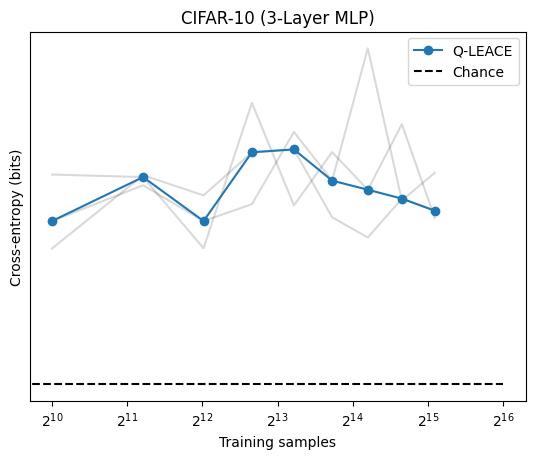

In [15]:
import matplotlib.pyplot as plt

for i in range(num_seeds):
    # plt.plot(results[i].sample_sizes[:-1], results[i].ce_curve, alpha=0.15, c="black")
    plt.plot(results_[i].sample_sizes[:-1], results_[i].ce_curve, alpha=0.15, c="black")
    # plt.plot(results_[i].sample_sizes[:-1], results_linear_[i].ce_curve, alpha=0.15, c="black")

# plt.plot(results[0].sample_sizes[:-1], curve, label="Original", marker="o")
plt.plot(results_[0].sample_sizes[:-1], curve_, label="Q-LEACE", marker="o")
# plt.plot(results_[0].sample_sizes[:-1], curve_linear_, label="LEACE", marker="o")

plt.hlines(np.log2(10), 0, 2 ** 16, label="Chance", linestyle="--", color="black")
plt.legend()
plt.xscale("log", base=2)
plt.xlabel("Training samples")
plt.ylabel("Cross-entropy (bits)")
plt.title("CIFAR-10 (3-Layer MLP)")
plt.yscale("log", base=2)

# add numbers to y axis
# locs, _ = plt.yticks()
# locs = np.log2(locs)
# locs = np.round(locs).astype(int)
# plt.yticks(2 ** locs, [f"2^{loc}" for loc in locs])


In [15]:
resnet = tv.models.resnet18(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
resnet.layer1[0]

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [17]:
from torchvision.models.resnet import BasicBlock

In [18]:
from torch import nn

class MlpBlock(nn.Module):
    def __init__(
        self, in_features: int, out_features: int, device = None, dtype = None
    ):
        super().__init__()

        self.linear1 = nn.Linear(
            in_features, out_features, bias=False, device=device, dtype=dtype
        )
        self.linear2 = nn.Linear(
            out_features, out_features, bias=False, device=device, dtype=dtype
        )
        self.bn1 = nn.BatchNorm1d(
            in_features, device=device, dtype=dtype
        )
        self.bn2 = nn.BatchNorm1d(
            out_features, device=device, dtype=dtype
        )
        self.downsample = nn.Linear(
            in_features, out_features, bias=False, device=device, dtype=dtype
        ) if in_features != out_features else None

    def forward(self, x):
        identity = x
    
        out = self.linear1(x)
        out = self.bn1(out)
        out = nn.functional.relu(out)

        out = self.linear2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        out = nn.functional.relu(out)

        return out

In [19]:
def to_bytes(x):
    return x.mul(255).byte()

def to_float(x):
    return x.float().div(255)


In [20]:
from torchvision.transforms.functional import to_pil_image

with torch.autocast("cuda"):
    vit = VitProbe(device=X.device)
    vit.fit(X_train, Y_train, verbose=True, reduce_lr_on_plateau=True, max_epochs=200, early_stop_epochs=50, augment=augmentor, batch_size=100)

Epoch:   0%|          | 0/200 [00:00<?, ?it/s, loss=3.39]

Epoch:  66%|██████▋   | 133/200 [18:38<09:23,  8.41s/it, loss=2.01]


In [21]:
vit.accuracy(X_test, Y_test, 128)

0.4794921875